In [2]:
import os
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras import backend as K
from keras.optimizers import Adam, SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load images into array
img_filename = glob.iglob("/content/drive/MyDrive/PIBD/dataset/imagette_grayscale/*.png")
img = np.array([np.array(cv2.imread(fname,cv2.IMREAD_GRAYSCALE)) for fname in img_filename])
img = cv2.normalize(img,  None, 0, 255, cv2.NORM_MINMAX)

mask_filename = glob.iglob("/content/drive/MyDrive/PIBD/dataset/imagette_mask/*.png")
mask = np.array([np.array(cv2.imread(fname,cv2.IMREAD_UNCHANGED)) for fname in mask_filename])
#normaliser le masque
mask = cv2.normalize(mask,  None, 0, 1, cv2.NORM_MINMAX)



In [ ]:
print(np.min(img), np.max(img), img.shape, type(img))
print(np.min(mask), np.max(mask), mask.shape, type(mask))

0 255 (980, 256, 256) <class 'numpy.ndarray'>
0 1 (980, 256, 256) <class 'numpy.ndarray'>


Text(0.5, 1.0, 'Image segmentée')

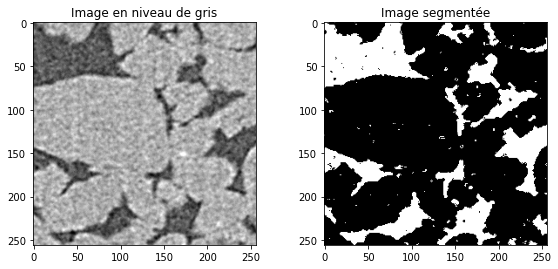

In [ ]:
#tracer l'image et son masque 
plt.figure(figsize=(20,9))
plt.subplot(2,4,2)
plt.imshow(img[200], cmap='gray')
plt.title('Image en niveau de gris')
plt.subplot(2,4,3)
plt.imshow(mask[200], cmap='gray')
plt.title('Image segmentée')

**Diviser les données** 

In [ ]:
#diviser les données en 70% pour l'entrainement, 20% pour le test et 10% pour validation
from sklearn.model_selection import train_test_split
train_ratio = 0.70
test_ratio = 0.20
validation_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(img, mask, test_size=1 - train_ratio)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

In [ ]:
print(len(x_train))
print(len(x_test))
len(x_val)

685
197


98

**Architecture de réseau de neurone convolutif** (Segnet) 

In [ ]:
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from tensorflow.core import * 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
import tensorflow.keras

def segnet(kernel=3):
    
    # encoder
    input_img = Input(shape=(256, 256, 1))

    conv_1 = Conv2D(64, (kernel, kernel), padding="same", strides= (1,1))(input_img)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Conv2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)
    

    x = MaxPooling2D()(conv_2)
    x = Dropout(0.5)(x)

    conv_3 = Conv2D(128, (kernel, kernel), padding="same")(x)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Conv2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    x = MaxPooling2D()(conv_4)
    x = Dropout(0.5)(x)
    
    conv_5 = Conv2D(256, (kernel, kernel), padding="same")(x)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Conv2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Conv2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    x = MaxPooling2D()(conv_7)
    x= Dropout(0.5)(x)

    conv_8 = Conv2D(512, (kernel, kernel), padding="same")(x)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Conv2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Conv2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    x = MaxPooling2D()(conv_10)
    x= Dropout(0.5)(x)

    conv_11 = Conv2D(512, (kernel, kernel), padding="same")(x)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Conv2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Conv2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    x = MaxPooling2D()(conv_13)
    x= Dropout(0.5)(x)
    print("Build enceder done..")

    # decoder
       
    x = UpSampling2D()(x)
    x= Dropout(0.5)(x)
    conv_14 = Conv2D(512, (3, 3), padding='same')(x)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation('relu')(conv_14)
    conv_15 = Conv2D(512, (3, 3), padding='same')(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation('relu')(conv_15)
    conv_16 = Conv2D(512, (3, 3), padding='same')(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation('relu')(conv_16)
    
    x = UpSampling2D()(conv_16)
    x= Dropout(0.5)(x)
    conv_17 = Conv2D(512, (3, 3), padding='same')(x)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation('relu')(conv_17)
    conv_18 = Conv2D(512, (3, 3), padding='same')(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation('relu')(conv_18)
    conv_19 = Conv2D(256, (3, 3), padding='same')(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation('relu')(conv_19)

    x = UpSampling2D()(conv_19)
    x= Dropout(0.5)(x)
    conv_20 = Conv2D(256, (3, 3), padding='same')(x)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation('relu')(conv_20)
    conv_21 = Conv2D(256, (3, 3), padding='same')(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation('relu')(conv_21)
    conv_22 = Conv2D(128, (3, 3), padding='same')(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation('relu')(conv_22)

    x = UpSampling2D()(conv_22)
    x = Dropout(0.5)(x)
    conv_23 = Conv2D(128, (3, 3), padding='same')(x)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation('relu')(conv_23)
    conv_24 = Conv2D(64, (3, 3), padding='same')(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation('relu')(conv_24)
    
    x = UpSampling2D()(conv_24)
    x = Dropout(0.5)(x)
    conv_25 = Conv2D(64, (3, 3), padding='same')(x)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation('relu')(conv_25)
    conv_26 = Conv2D(1, (3, 3), padding='same')(conv_25)
    conv_26 = BatchNormalization()(conv_26)
    outputs = Activation('sigmoid')(conv_26)
    
    print("Build decoder done..")

    model = Model(inputs=input_img, outputs=outputs, name="SegNet")

    return model

In [ ]:
#compiler le modèle segnet()
model= segnet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Build enceder done..
Build decoder done..


Entrainer le modèle

In [ ]:
history = model.fit(x_train, y_train, 
                    epochs=100,
                    batch_size=8,
                    validation_data=(x_val, y_val))

Epoch 1/100
86/86 [==============================] - 46s 408ms/step - loss: 0.5869 - accuracy: 0.7657 - val_loss: 0.5265 - val_accuracy: 0.7761
Epoch 2/100
86/86 [==============================] - 34s 395ms/step - loss: 0.4505 - accuracy: 0.8846 - val_loss: 0.4306 - val_accuracy: 0.8942
Epoch 3/100
86/86 [==============================] - 35s 410ms/step - loss: 0.4088 - accuracy: 0.9036 - val_loss: 0.3838 - val_accuracy: 0.9138
Epoch 4/100
86/86 [==============================] - 37s 427ms/step - loss: 0.3737 - accuracy: 0.9146 - val_loss: 0.3617 - val_accuracy: 0.9144
Epoch 5/100
86/86 [==============================] - 36s 421ms/step - loss: 0.3457 - accuracy: 0.9208 - val_loss: 0.3349 - val_accuracy: 0.9281
Epoch 6/100
86/86 [==============================] - 37s 425ms/step - loss: 0.3237 - accuracy: 0.9257 - val_loss: 0.3615 - val_accuracy: 0.9047
Epoch 7/100
86/86 [==============================] - 36s 424ms/step - loss: 0.3031 - accuracy: 0.9299 - val_loss: 0.3170 - val_accuracy:

**Evaluer le modèle** 

In [ ]:
results= model.evaluate(x_test, y_test, batch_size=8)

25/25 [==============================] - 3s 137ms/step - loss: 0.0847 - accuracy: 0.9688


**Visualisation des résultats**

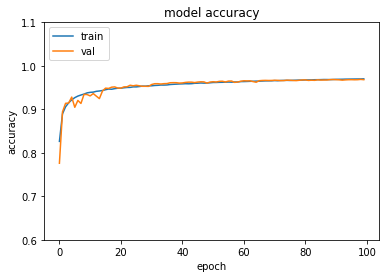

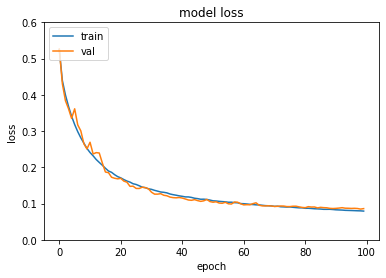

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.yticks(list(np.arange(0.6, 1.1, 0.10)))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yticks(list(np.arange(0.0, 0.7, 0.10)))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Prédiction d'image**

In [ ]:
Y_pred = model.predict(x_test, verbose=1)>0.5

7/7 [==============================] - 3s 418ms/step


(256, 256)


Text(0.5, 1.0, 'Image prédit')

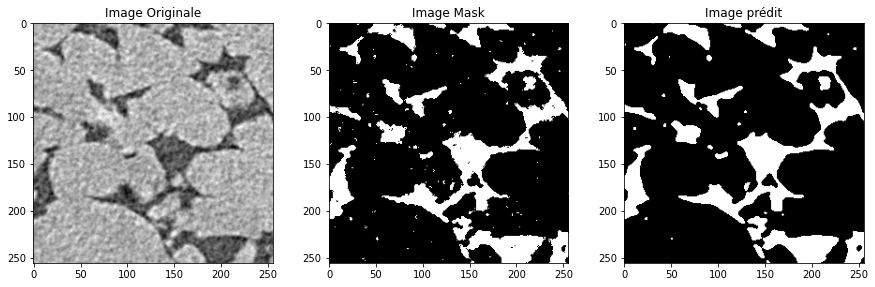

In [ ]:
id = 70
print(x_test[id].shape)
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(3,3,1)
ax1.imshow((x_test[id]).reshape(256,256),cmap='gray')
plt.title('Image Originale')
ax2 = fig.add_subplot(3,3,2)
ax2.imshow((y_test[id]).reshape(256,256),cmap='gray')
plt.title('Image Mask')
ax3 = fig.add_subplot(3,3,3)
ax3.imshow((Y_pred[id]).reshape(256,256),cmap='gray')
plt.title('Image prédit')

In [5]:
#charger le modéle 
reconstructed_model = tensorflow.keras.models.load_model("/content/drive/My Drive/PIBD/saved_model_SegNoAug96.h5")

In [ ]:
Y_pred = reconstructed_model.predict(x_test, verbose=1)>0.5


7/7 [==============================] - 3s 409ms/step


In [ ]:
y_pred=Y_pred.reshape(Y_pred.shape[0],Y_pred.shape[1],Y_pred.shape[2])

In [ ]:
"metrique IOU"
intersection = np.logical_and(y_test, y_pred)
union = np.logical_or(y_test, y_pred)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU is %s" % iou_score)

IoU is 0.8904351292427435


**Différence entre image prédite et image masque** (Matrice de confusion)

In [ ]:
def get_confusion_matrix_intersection_mats(groundtruth, predicted):
    confusion_matrix_arrs = {}

    groundtruth_inverse = np.logical_not(groundtruth)
    predicted_inverse = np.logical_not(predicted)

    confusion_matrix_arrs['tp'] = np.logical_and(groundtruth, predicted)
    confusion_matrix_arrs['tn'] = np.logical_and(groundtruth_inverse, predicted_inverse)
    confusion_matrix_arrs['fp'] = np.logical_and(groundtruth_inverse, predicted)
    confusion_matrix_arrs['fn'] = np.logical_and(groundtruth, predicted_inverse)

    return confusion_matrix_arrs

white - TP
Magenta - FP
Yellow - FN
Black - TN


(-0.5, 255.5, 255.5, -0.5)

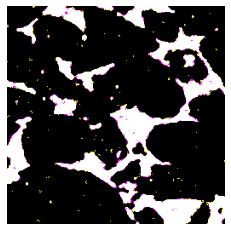

In [ ]:
def get_confusion_matrix_overlaid_mask(image, groundtruth, predicted, colors):
    """
    Renvoie la superposition de l'image avec un masque de couleur où TP, FP, FN, TN sont chacun une couleur donnée par le dictionnaire de couleurs. 
    """
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    masks = get_confusion_matrix_intersection_mats(groundtruth, predicted)
    color_mask = np.zeros_like(image)
    for label, mask in masks.items():
        color = colors[label]
        mask_rgb = np.zeros_like(image)
        mask_rgb[mask != 0] = color
        color_mask += mask_rgb
    return cv2.addWeighted(image, alpha, color_mask, 1 - alpha, 0)
alpha = 0

confusion_matrix_colors = {
   'tp': (255, 255, 255),  #white
   'fp': (255, 0, 255),  #magenta
   'fn': (255, 255, 0),  #yellow
   'tn': (0,0,0)     #black
   }
validation_mask = get_confusion_matrix_overlaid_mask(x_test[70], y_test[70], y_pred[70], confusion_matrix_colors)
print('white - TP')
print('Magenta - FP')
print('Yellow - FN')
print('Black - TN')

plt.figure(figsize=(4,4))
plt.imshow(validation_mask)
plt.axis('off')
